### Benchmark model 

#### Benchmark with split

First we select the 10 top features

In [4]:
import pandas as pd
from helper_functions import *
import importlib

In [6]:
train_df = pd.read_csv('data/train.csv')

In [7]:
# This time we train on the complete set
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

# We remove categorical features first
X = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X = X.drop(X.columns[X.isnull().any(axis=0)], axis=1)

# Because of the skewed distribution we take the log of the sale price
y = np.log1p(y)

In [8]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(k=10)
sel.fit(X, y)

SelectKBest(k=10, score_func=<function f_classif at 0x0000020C658E1730>)

In [9]:
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': sel.scores_})

In [10]:
feature_scores.sort_values('Score', ascending=False).head(10)

,Feature,Score
3,OverallQual,5.729183
31,MiscVal,3.756250
14,GrLivArea,3.435110
2,LotArea,3.285852
23,GarageCars,2.861594
17,FullBath,2.678847
24,GarageArea,2.583341
11,1stFlrSF,2.338620
10,TotalBsmtSF,2.315290
5,YearBuilt,2.310198


In [11]:
top_columns = feature_scores.sort_values('Score', ascending=False).head(10)['Feature']

In [12]:
X[top_columns].head()

,OverallQual,MiscVal,GrLivArea,LotArea,GarageCars,FullBath,GarageArea,1stFlrSF,TotalBsmtSF,YearBuilt
0,7,0,1710,8450,2,2,548,856,856,2003
1,6,0,1262,9600,2,2,460,1262,1262,1976
2,7,0,1786,11250,2,2,608,920,920,2001
3,7,0,1717,9550,3,1,642,961,756,1915
4,8,0,2198,14260,3,2,836,1145,1145,2000


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[top_columns], y, test_size=.3, random_state=42)

In [14]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [15]:
y_hat = reg.predict(X_test)

In [16]:
print_benchmark(y_test, y_hat)

R2-score: 0.834722700415
RMSE (log): 0.1674463871816331


#### And now train on the whole set provided

In [17]:
train_df = pd.read_csv('data/train.csv')
X = train_df.drop('SalePrice', axis=1)
y = np.log(train_df['SalePrice'])

In [18]:
reg = LinearRegression(normalize=True)
reg.fit(X[top_columns], y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [19]:
y_hat = reg.predict(X[top_columns])

In [20]:
print_benchmark(y, y_hat)

R2-score: 0.818633945381
RMSE (log): 0.1700566727323582


### We predict on the test set

In [21]:
test_df = pd.read_csv('data/test.csv')
X = test_df[top_columns]

In [22]:
# How many null rows in each column
null_columns = X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

GarageCars     1
GarageArea     1
TotalBsmtSF    1
dtype: int64

In [23]:
# We impute garage are with
X.loc[X['GarageArea'].isnull(), 'GarageArea'] = 0
X.loc[X['GarageCars'].isnull(), 'GarageCars'] = 0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
X.loc[X['TotalBsmtSF'].isnull(), 'TotalBsmtSF'] = np.mean(X['TotalBsmtSF'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
# How many null rows in each column
null_columns = X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

Series([], dtype: float64)

In [26]:
y_hat = reg.predict(X)

In [27]:
def draw_sanity_check(pred, in_dollars = True):
    if in_dollars == False:
        pred = np.expm1(pred)
    train_df = pd.read_csv('data/train.csv')
    test_df = pd.read_csv('data/test.csv')
    fig, ax = plt.subplots(1, figsize=(8, 6), sharey=True)
    ax.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=.4)
    ax.set_title('Baseline vs Prediction')
    ax.scatter(test_df['GrLivArea'], pred, alpha=.4)
    print('Mean of Salesprice in Training-Data: %.2f' % train_df['SalePrice'].mean())
    print('Mean of Salesprice in predictions: %.2f' % pred.mean())
    difference = pred.mean() - train_df['SalePrice'].mean()
    print('Difference in means is: %s' % difference)
    if np.abs(difference) > 5000:
        print('IMPORTANT: There is something wrong with your predictions!!!')
    plt.show()

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 12.01
Difference in means is: -180909.183842
IMPORTANT: There is something wrong with your predictions!!!


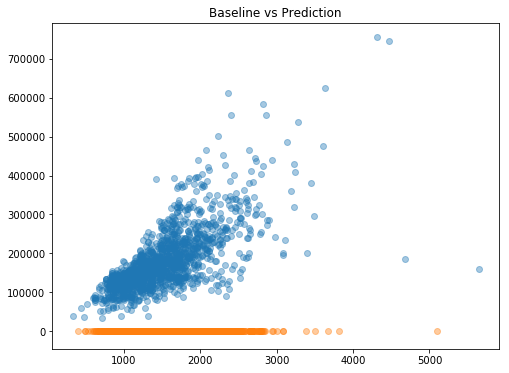

In [28]:
draw_sanity_check(y_hat, )

In [344]:
write_submission(test_df, y_hat)

File written to C:\Source\predicting-house-prices\submissions\20180710220107.csv
